Seguindo tutorial e adaptando ao meu contexto.
Site: [Guia Básico para Processamento de Linguagem Natural (NLP)](https://www.datageeks.com.br/processamento-de-linguagem-natural/)

Utilizar como referência para pré-processamento (Kaggle): [Pré-processamento para NLP](https://www.kaggle.com/code/cassioall/pr-processamento-para-nlp)

In [42]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix

# Bag-of-Words
Essa técnica é comumente utilizada quando é necessário extrair características de um texto. Em específico, a ideia do algoritmo está em contar a frequência em que as palavras aparecem no documento.

## Pré-processamento
De modo a garantir uma maior qualidade no resultado do algortimo, um bom pré-processamento é extramamente importante.

Até o momento, será utilizado a base dados "akcdata" que foi extraída do seguinte repositório: https://github.com/tmfilho/akcdata. Essa base contém a informações de 277 raças de cachorro. Essas informações foram extraídas do [American Kennel Club website](https://www.akc.org/).

Para o nosso proprósito, utilizaremos o campo **"description"** de cada uma dessas raças. As drescrições possuem em média 2 a 3 parágrafos. Dessa maneira precisaremos segmentar estes textos em tokens (adicionar um link para o tópico). Mas antes, será feito uma limpeza para eliminar tudo o que não será útil para a análise de texto.

Observação: adiconei um rótulo **"breed"** para a primeira coluna. Por algum motivo na base original estava em branco.

In [43]:
import pandas as pd

breeds = pd.read_csv("../akc-data/akc-data-latest.csv")
breeds.columns=['breed','description','temperament','popularity','min_height','max_height','min_weight','max_weight','min_expectancy','max_expectancy','group','grooming_frequency_value','grooming_frequency_category','shedding_value','shedding_category','energy_level_value','energy_level_category','trainability_value','trainability_category','demeanor_value','demeanor_category']

breeds.head()

,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,60.96,71.12,31.751466,58.967008,10.0,13.0,...,0.8,Daily Brushing,0.6,Seasonal,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly


In [44]:
breeds.describe()

,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
count,277.000000,277.000000,275.000000,275.000000,274.000000,274.000000,270.000000,257.000000,271.000000,253.000000,252.000000
mean,44.225801,52.720588,17.888858,27.291416,11.306569,13.832117,0.425926,0.529183,0.712915,0.624506,0.620635
std,14.238298,15.885454,12.290600,19.061416,1.817949,2.016668,0.198306,0.189068,0.168927,0.247271,0.201713
min,12.700000,17.780000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000
25%,33.020000,38.100000,8.164663,12.927383,10.000000,13.000000,0.200000,0.400000,0.600000,0.400000,0.400000
50%,45.085000,53.340000,15.875733,24.947580,12.000000,14.000000,0.400000,0.600000,0.600000,0.600000,0.600000
75%,55.880000,66.040000,22.679619,34.019428,12.000000,15.000000,0.600000,0.600000,0.800000,0.800000,0.800000
max,76.200000,88.900000,68.038855,108.862169,16.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Limpando texto utilizando expressões regulares

In [62]:
def standardize_text(data, column):
    #Caso necessário, adicionar outros tipos de limpeza.
    data[column] = data[column].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    data[column] = data[column].str.lower()
    return data

clean_breeds_description = standardize_text(breeds, 'description')
clean_breeds_description.to_csv("clean_data1.csv")

clean_breeds_description['description']

0      the affen’s apish look has been described many...
1      the afghan hound is an ancient breed, his whol...
2      the airedale terrier is the largest of all ter...
3      akitas are burly, heavy-boned spitz-type dogs ...
4      the alaskan malamute stands 23 to 25 inches at...
                             ...                        
272    wvs are close relatives of vizslas but a disti...
273    the overall appearance of the working kelpie i...
274    the xoloitzcuintli (show-low-eats-queen-tlee) ...
275    for centuries the yakutian laika was an irrepl...
276    the yorkshire terrier is a compact, toy-size t...
Name: description, Length: 277, dtype: object

In [55]:
from nltk.tokenize import RegexpTokenizer

# Quebrando os dados (tokenização).
tokenizer = RegexpTokenizer(r'\w+')

# Adicionando um campo (coluna) que recebe um lista com as sentenças quebradas.
clean_breeds_description['tokens'] = clean_breeds_description['description'].apply(tokenizer.tokenize)

clean_breeds_description['tokens'].head()

0    [the, affen, s, apish, look, has, been, descri...
1    [the, afghan, hound, is, an, ancient, breed, h...
2    [the, airedale, terrier, is, the, largest, of,...
3    [akitas, are, burly, heavy, boned, spitz, type...
4    [the, alaskan, malamute, stands, 23, to, 25, i...
Name: tokens, dtype: object

In [58]:
all_words = [word for tokens in clean_breeds_description['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_breeds_description['tokens']]
VOCAB = sorted(list(set(all_words)))
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB)))
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

43484 Quantidade total de palavras, com um vocabulario de 5323
Tamanho máximo de uma sentença 372


Como a distribuição das sentenças por quantidade de palavras indica a qualidade da base de dados.

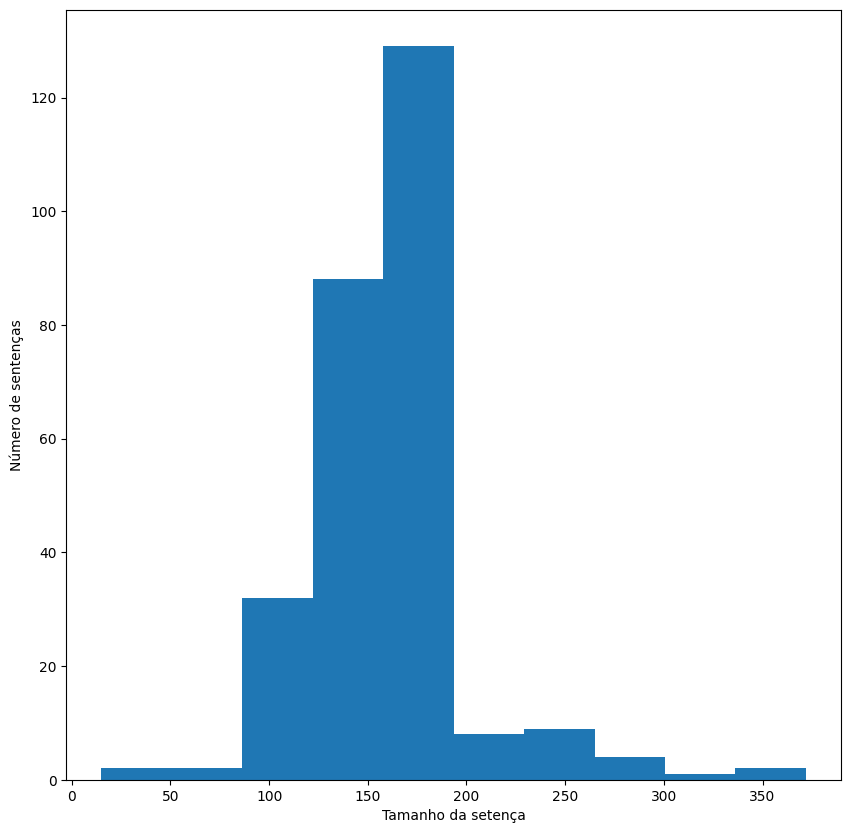

In [59]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença')
plt.ylabel('Número de sentenças')
plt.hist(sentence_lengths)
plt.show()

In [60]:
clean_breeds_description['tokens']

0      [the, affen, s, apish, look, has, been, descri...
1      [the, afghan, hound, is, an, ancient, breed, h...
2      [the, airedale, terrier, is, the, largest, of,...
3      [akitas, are, burly, heavy, boned, spitz, type...
4      [the, alaskan, malamute, stands, 23, to, 25, i...
                             ...                        
272    [wvs, are, close, relatives, of, vizslas, but,...
273    [the, overall, appearance, of, the, working, k...
274    [the, xoloitzcuintli, show, low, eats, queen, ...
275    [for, centuries, the, yakutian, laika, was, an...
276    [the, yorkshire, terrier, is, a, compact, toy,...
Name: tokens, Length: 277, dtype: object